In [56]:
import random

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


In [77]:
SEQ_SIZE = 15
EPOCHS = 10
TRAIN_STATIONS = 15
TEST_STATIONS = 5
VALIDATION_PERCENTAGE = 0.2
BATCH_SIZE = 32

In [78]:
def resample_and_save(read_path='../data/labeled', save_path='../data/labeled_daily'):
    files = os.listdir(read_path)

    for s in files:
        station = pd.read_csv(f'{read_path}/{s}')
        station['station_code'] = s[:-4]
        
        station = preprocess(station, resample='D')
        
        station.to_csv(f'{save_path}/{s}')

In [79]:
def load_stations(path, count, shuffle = False):
    files = os.listdir(path)
    
    if shuffle:
        random.shuffle(files)
    else:
        files = sorted(files)
    
    dataframes = []
    for s in files[:count]:
        station = pd.read_csv(f'{path}/{s}')
        station['station_code'] = s[:-4]
        dataframes.append(station)

    return pd.concat(dataframes, ignore_index=True), files[:count], files[count:]

In [40]:
def load_station(path, station_name, resample=None):
    df = pd.read_csv(f'{path}/{station_name}')
    df['station_code'] = station_name[:-4]
    
    if resample is not None:
        df = resample(df, resample) 

    return df

In [80]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(df, scale=False, resample=None):
    # Initial processing
    data = df[['station_code', 'measure_date', 'HS', 'no_snow', 'anomaly']].copy()
    data['measure_date'] = pd.to_datetime(data['measure_date']).dt.tz_localize(None)
    data.dropna(inplace=True)

    # Scaling
    if scale:
        def scale_group(group):
            scaler = MinMaxScaler()
            # TODO: Could try standardizing and then scaling
            group['HS'] = scaler.fit_transform(group[['HS']])
            return group

        data = data.groupby('station_code').apply(scale_group)

    # Resampling
    if resample:
        data.set_index('measure_date', inplace=True)
        data = data.groupby('station_code').resample(resample).agg({
            'HS': lambda x: x.iloc[np.argmax(np.abs(x.values - x.mean()))],
            'no_snow': lambda x: x.value_counts().idxmax(), # TODO: Could try x.any() to improve predictions?
            'anomaly': lambda x: x.any()
        }).reset_index()

    return data

In [81]:
# TODO: Change length
def split_stations_into_seqs(df, y, target, seq_size):
    all_seqs = []

    for name, station in df.groupby('station_code'):
        y_values = station[y].values
        target_values = station[target].values

        num_sequences = len(y_values) - seq_size

        sequences_array = np.empty((num_sequences, 2), dtype=object)

        for i in range(num_sequences):
            sequences_array[i, 0] = y_values[i: i + seq_size]
            sequences_array[i, 1] = target_values[i: i + seq_size].any()

        all_seqs.extend(sequences_array)


    all_seqs = np.array(all_seqs)

    # TODO: Try if it works better with shuffle
    np.random.shuffle(all_seqs)
    
    return np.stack(np.array(all_seqs[:, 0])), np.asarray(all_seqs[:, 1]).astype(np.float32)

In [82]:
def create_train_validation_split(sequences, percentage=0.3):
    total_len = len(sequences[1])
    validation_len = int(percentage * total_len)
    
    train_X = sequences[0][0:total_len - validation_len]
    train_y = sequences[1][0:total_len - validation_len]
    
    val_X = sequences[0][total_len - validation_len:]
    val_y = sequences[1][total_len - validation_len:]
    
    return train_X, train_y, val_X, val_y

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_data(dfs, y='HS', target='no_snow', predictions=None):
    if not isinstance(dfs, list):
        dfs = [dfs]  # Convert a single df to a list for consistency

    if not isinstance(y, list):
        y = [y] * len(dfs)

    if not isinstance(target, list):
        target = [target] * len(dfs)

    if predictions:
        rows = len(dfs) * 2
    else:
        rows = len(dfs)

    fig, axes = plt.subplots(rows, 1, figsize=(20, 5 * rows))

    if len(dfs) == 1:
        axes = [axes]

    for i, df in enumerate(dfs):
        plot_df = df.copy()
        plot_df.index = pd.to_datetime(plot_df['measure_date'])
        station_code = plot_df['station_code'].iloc[0]
        
        # Plot original data
        ax = axes[2 * i] if predictions else axes[i]
        ax.set_xlabel('Date')
        ax.set_ylabel(y[i])
        ax.set_title(f'Station: {station_code} | Original Data with Anomalies Highlighted')
        ax.plot(plot_df.index, plot_df[y[i]], label='Data', marker='o', linestyle='-', ms=4)
        ax.scatter(plot_df[plot_df[target[i]]].index, plot_df[plot_df[target[i]]][y[i]], color='red', label='Anomalies', zorder=5, s=20)
        ax.legend()

        # Plot predictions
        if predictions:
            ax = axes[2 * i + 1]
            ax.set_xlabel('Date')
            ax.set_ylabel(y[i])
            ax.set_title(f'Station: {station_code} | Predicted Data with Anomalies Highlighted')
            ax.plot(plot_df.index, plot_df[y[i]], label='Data', marker='o', linestyle='-', ms=4)
            ax.scatter(plot_df[predictions[i]].index, plot_df[predictions[i]][y[i]], color='green', label='Predicted Anomalies', zorder=5, s=20)
            # ax.scatter(plot_df.index, plot_df[predictions[i]][y[i]], color='green', label='Predicted Anomalies', zorder=5, s=20)
            ax.legend()

    plt.tight_layout()
    plt.show()

def plot_keras_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [60]:
stations_df, train_station_names, test_station_names  = load_stations('../data/labeled_daily', TRAIN_STATIONS, shuffle=True)

In [61]:
preprocessed_stations_df = preprocess(stations_df)

In [62]:
sequences = split_stations_into_seqs(preprocessed_stations_df, 'HS', 'no_snow', seq_size=SEQ_SIZE)

train_X, train_y, val_X, val_y = create_train_validation_split(sequences, percentage=VALIDATION_PERCENTAGE)

In [84]:
sequences[0].shape, sequences[1].shape, train_X.shape, train_y.shape, val_X.shape, val_y.shape

((127581, 15), (127581,), (102065, 15, 1), (102065,), (25516, 15, 1), (25516,))

In [86]:
from datetime import datetime
from keras.src.layers import CuDNNLSTM, BatchNormalization, Dropout
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.src.callbacks import TensorBoard
from datetime import datetime


current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f"{current_time}_epochs-{EPOCHS}_seq-{SEQ_SIZE}_train-{TRAIN_STATIONS}_test-{TEST_STATIONS}_val-{VALIDATION_PERCENTAGE}"
log_dir = f"../logs/{model_name}"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

train_X = np.reshape(train_X, (-1, SEQ_SIZE, 1))
val_X = np.reshape(val_X, (-1, SEQ_SIZE, 1))

model = Sequential()
model.add(CuDNNLSTM(128, input_shape=train_X.shape[1:], return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(CuDNNLSTM(128, input_shape=train_X.shape[1:]))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-6),
    metrics=['accuracy']
)
hist = model.fit(
    x=train_X,
    y=train_y,
    validation_data=(val_X, val_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tensorboard_callback]
)

Epoch 1/50
3190/3190 [==============================] - 35s 10ms/step - loss: 0.2040 - accuracy: 0.9209 - val_loss: 0.1837 - val_accuracy: 0.9318
Epoch 2/50
3190/3190 [==============================] - 25s 8ms/step - loss: 0.1867 - accuracy: 0.9287 - val_loss: 0.1683 - val_accuracy: 0.9369
Epoch 3/50
3190/3190 [==============================] - 35s 11ms/step - loss: 0.1778 - accuracy: 0.9322 - val_loss: 0.1691 - val_accuracy: 0.9299
Epoch 4/50
3190/3190 [==============================] - 37s 12ms/step - loss: 0.1707 - accuracy: 0.9349 - val_loss: 0.1556 - val_accuracy: 0.9407
Epoch 5/50
3190/3190 [==============================] - 27s 8ms/step - loss: 0.1657 - accuracy: 0.9369 - val_loss: 0.1597 - val_accuracy: 0.9398
Epoch 6/50
3190/3190 [==============================] - 26s 8ms/step - loss: 0.1609 - accuracy: 0.9384 - val_loss: 0.1540 - val_accuracy: 0.9404
Epoch 7/50
3190/3190 [==============================] - 26s 8ms/step - loss: 0.1575 - accuracy: 0.9396 - val_loss: 0.1474 - val

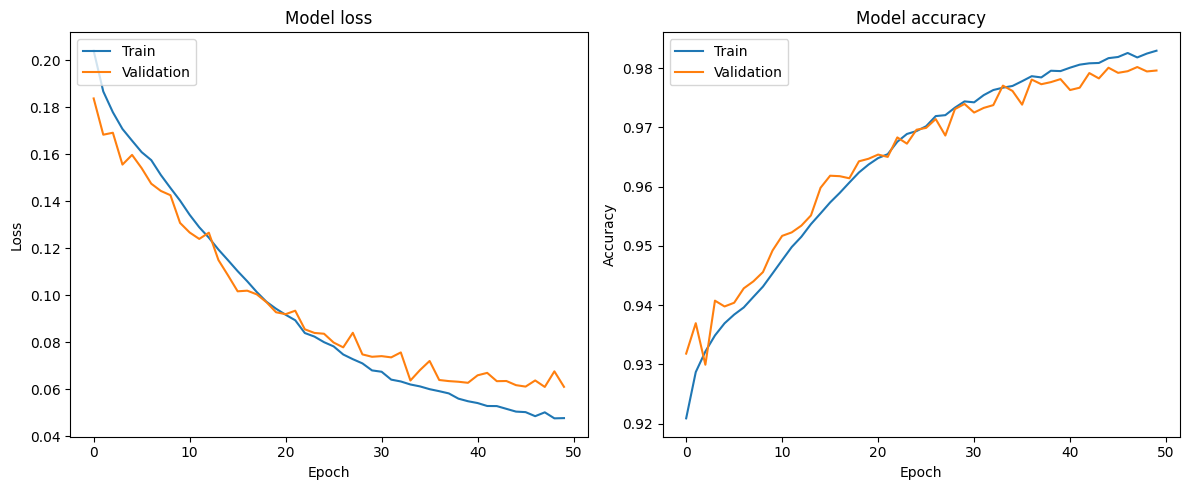

In [87]:
plot_keras_history(hist)

In [70]:
test_dfs = [preprocess(load_station("../data/labeled_daily", st)) for st in test_station_names]

290/290 [==============================] - 1s 2ms/step
Station: FNH2, Accuracy: 0.6777358490566038
302/302 [==============================] - 1s 2ms/step
Station: ARO3, Accuracy: 0.650368524862452
151/151 [==============================] - 0s 2ms/step
Station: LAG3, Accuracy: 0.650103519668737
290/290 [==============================] - 1s 2ms/step
Station: AMD2, Accuracy: 0.6044953533607089
267/267 [==============================] - 1s 2ms/step
Station: FOU2, Accuracy: 0.8877287658376349
Avg accuracy: 0.6940864025572274


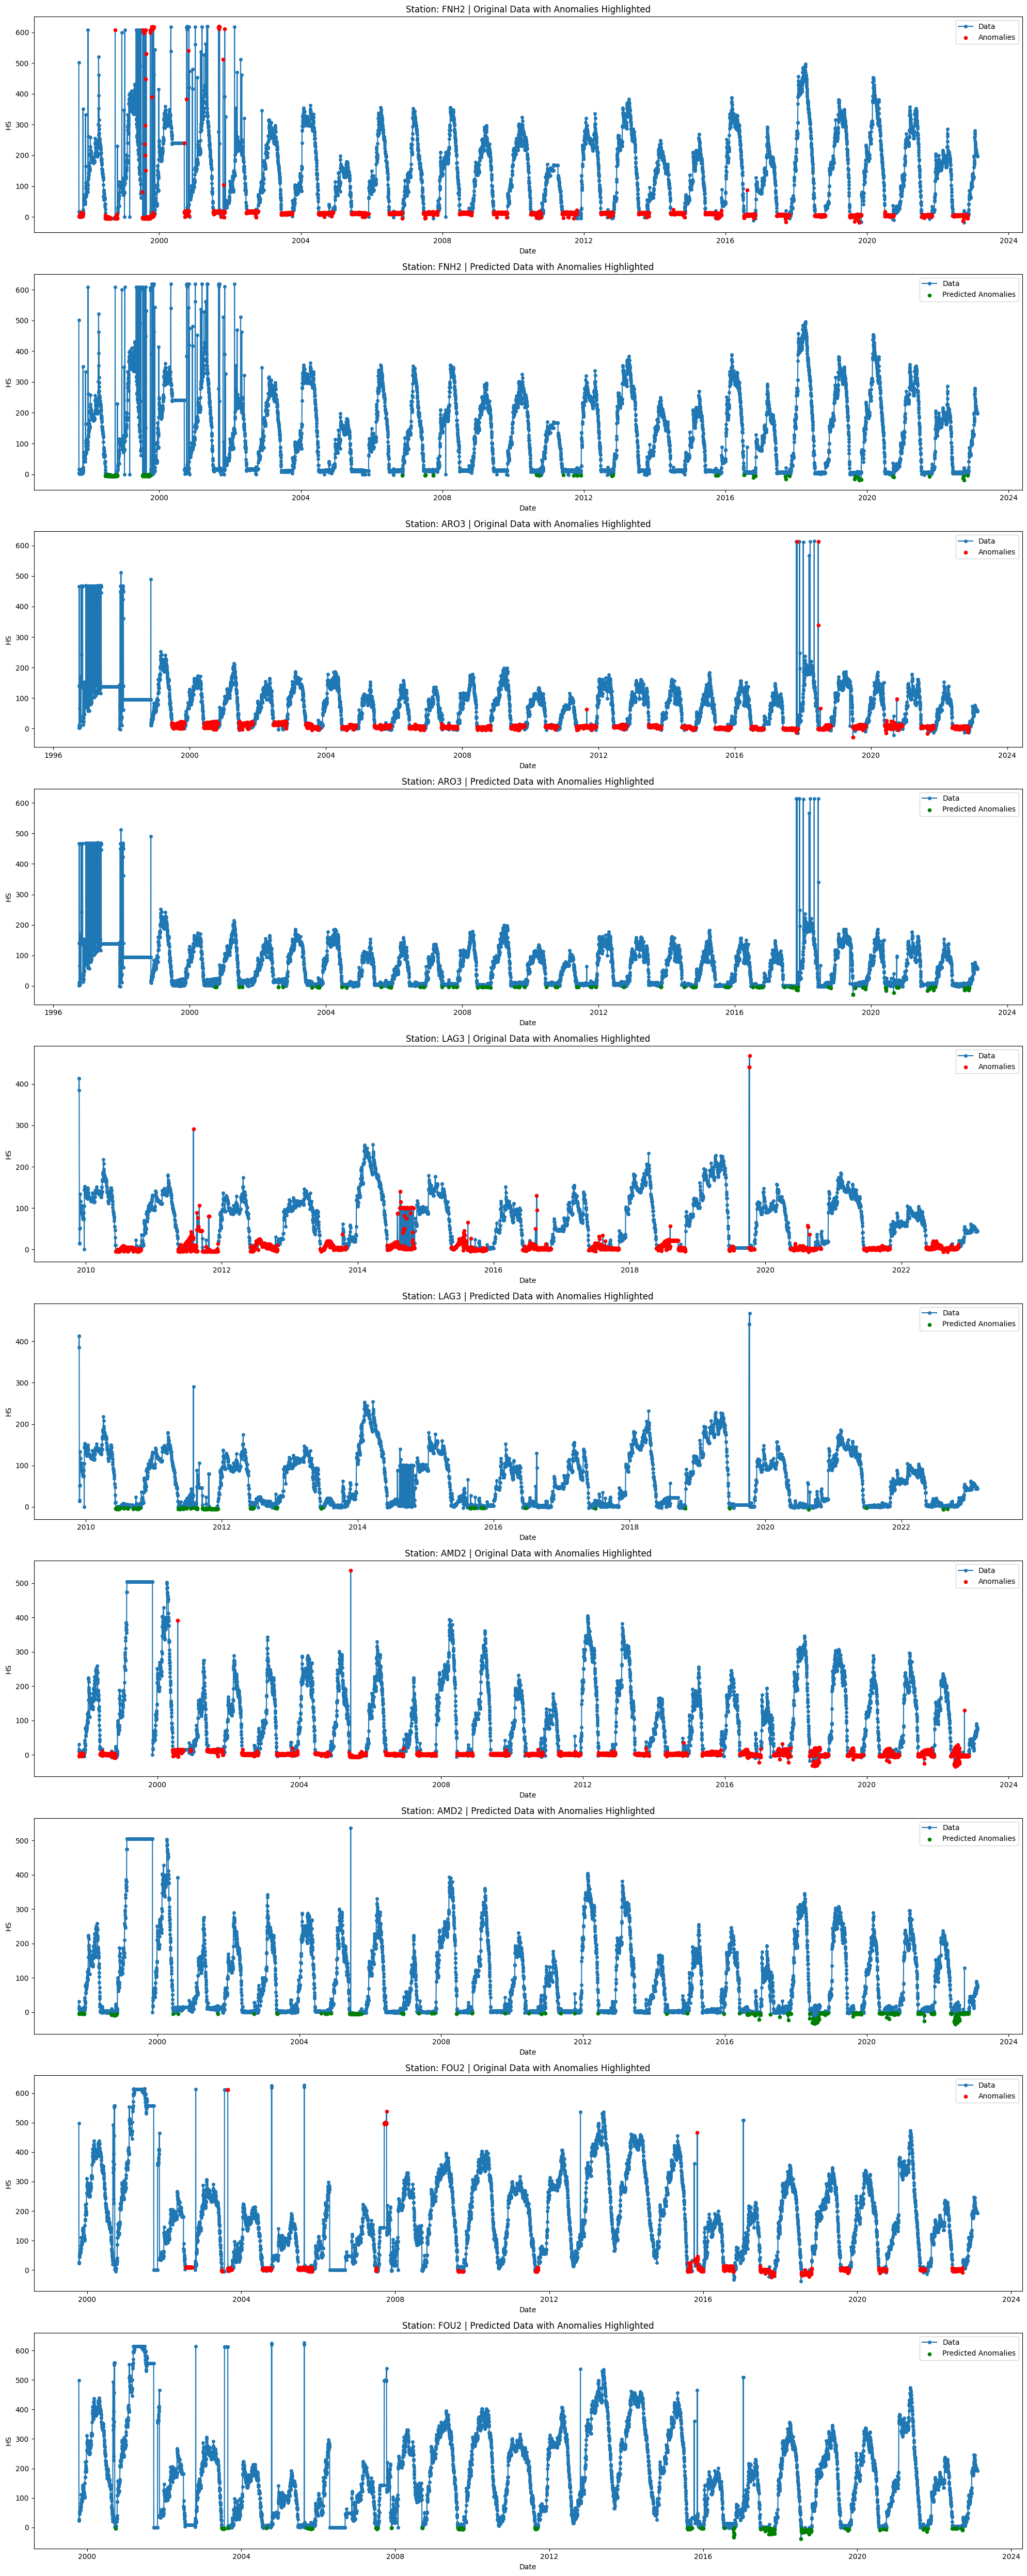

In [88]:
preds = []
accs = []

for test in test_dfs:
    predictions = model.predict(test['HS'])
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    correct_predictions = np.sum(predicted_labels == test['no_snow'].values.flatten())
    accuracy = correct_predictions / len(test)
    print(f"Station: {test.iloc[0]['station_code']}, Accuracy: {accuracy}")
    
    accs.append(accuracy)
    preds.append(predictions > 0.5)
    
print(f"Avg accuracy: {sum(accs) / len(test_dfs)}")

plot_data(test_dfs, predictions=preds)  
    